# Introduction

## Imports

In [1]:
import pandas as pd

import numpy as np

import os

In [2]:
# load target
# I include this in the imports section because its as essential as an importa
target = pd.read_csv('../data/target_competencia_ids.csv')

# to avoid misunderstandings with data when predicting, and avoid accidentally predicting value zero
target.obj = np.nan

In [127]:
# days to consider
all_days = [18,19,20,21,22,23,24,25,26]

## Data info

In [3]:
for file in os.listdir('../data/'):
    print(file + '\t\t\t\t\t\t' + str(os.stat("../data/" + file).st_size/1000000))

auctions.csv						2412.11824
.ipynb_checkpoints						0.004096
target_competencia_ids.csv						0.200915
installs.csv						123.502317
desc.json						0.009146
Recomendaciones y aclaraciones.docx						0.006909
clicks.csv						16.147446
events.csv						2252.988966


# Useful functions

## General

In [110]:
# target ids related
def get_target_ids():
    return target['ref_hash'].apply(lambda x: x[:-3]).unique()

def get_target_ids_chunk(chunk_num):
    """ chunk num can go from 1 to 41"""
    chunk_size = 100
    start = (chunk_num - 1) * chunk_size
    stop = chunk_size * chunk_num
    return get_target_ids()[start:stop]

In [4]:
# para guardar predicciones
import time
def get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name, submission_description = "no description"):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(get_filename(authors_name, timestamp), index=False)
    save_description(authors_name, timestamp, submission_description)

In [5]:
# play a sound when whole notebook finished executing
import os
def ring(duration = 1, freq = 1500):
    """ play tone of duration in seconds and freq in Hz. """
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

## Dfs loading functions

In [128]:
clicks_dtypes = {'advertiser_id':'category',
                 'action_id':'category',
                 'source_id':'category',
                 'country_code':'category',
                 'latitude':'float64',
                 'longitude':'float64',
                 'wifi_connection':'bool',
                 'carrier_id':'category',
                 'trans_id':'category',
                 'os_minor':'category',
                 'agent_device':'category',
                 'os_major':'category',
                 'specs_brand':'category',
                 'brand':'category',
                 'timeToClick':'float64',
                 'touchX':'object',
                 'touchY':'object',
                 'ref_type':'category',
                 'ref_hash':'category'}

def load_clicks(users=get_target_ids(), days=all_days):
    """ load clicks csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively."""
    iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
    def load_condition(chunk):
        return chunk['ref_hash'].isin(users) & chunk['date'].dt.day.isin(days)
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_clicks)
    return df

In [129]:
installs_dtypes = {"application_id":          "category",
                   "ref_type":                "category",
                   "ref_hash":                "category",
                   "click_hash":             "category",
                   "attributed":               "bool",
                   "implicit":                 "bool",
                   "device_countrycode":      "category",
                   "device_brand":          "category",
                   "device_model":          "category",
                   "session_user_agent":     "category",
                   "user_agent":             "category",
                   "event_uuid":             "category",
                   "kind":                   "category",
                   "wifi":                   "category",
                   "trans_id":               "category",
                   "ip_address":              "category",
                   "device_language":       "category"}

def load_installs(users=get_target_ids(), days=all_days):
    """ load installs csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively."""
    df_installs = pd.read_csv('../data/installs.csv', engine='c', dtype=installs_dtypes, parse_dates=['created'])
    def load_condition(df):
        return df['ref_hash'].isin(users) & df['date'].dt.day.isin(days)
    df = df_installs.loc[condition(df_installs)]
    return df

In [130]:
events_dtypes = {"index":                   "category",
                 "event_id":                "category",
                 "ref_type":                "category",
                 "ref_hash":                "category",
                 "application_id":          "category",
                 "attributed":               "bool",
                 "device_countrycode":      "category",
                 "device_os_version":     "category",
                 "device_brand":          "category",
                 "device_model":          "category",
                 "device_city":           "category",
                 "session_user_agent":    "category",
                 "trans_id":               "category",
                 "user_agent":            "category",
                 "event_uuid":             "category",
                 "carrier":               "category",
                 "kind":                  "category",
                 "device_os":             "category",
                 "wifi":                     "bool",
                 "connection_type":        "category",
                 "ip_address":              "category",
                 "device_language":       "category"}

def load_events(users=get_target_ids(), days=all_days):
    """ load events csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively."""
    iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
    def load_condition(chunk):
        return chunk['ref_hash'].isin(users) & chunk['date'].dt.day.isin(days)
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_events)
    return df

In [131]:
auctions_dtypes = {'device_id':'category',
                 'ref_type_id':'category',
                 'source_id':'category'}

def load_auctions(users=get_target_ids(), days=all_days):
    """ load auctions csv, only users and days specified in users and days lists.
    If lists left empty, consider whole set of users and days respectively."""
    iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
    def load_condition(chunk):
        return chunk['device_id'].isin(users) & chunk['date'].dt.day.isin(days)
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_auctions)
    return df

# Recommended bibliography

- [Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA): Introduction to survival analysis and the lifelines lib in python. Shows simple example (aka, theres code!!)
- [Tristan Boudreault | Survival analysis for conversion rates](https://www.youtube.com/watch?v=oui1hx2bM2o): Estudio de caso: Shopify. From pyData conference in Amsterdam
- [Introduction to survival analysis](https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis): by lifelines

#### Pseudo resumen de cosas utiles para aplicar
Para survival analysis se necesitan dos cosas:
- an array of durations
- either a boolean or binary array representing whether the “death” was observed or not (alternatively an individual can be censored).

# Df loading

## Clicks

In [4]:
clicks_dtypes = {'advertiser_id':'category',
                 'action_id':'category',
                 'source_id':'category',
                 'country_code':'category',
                 'latitude':'float64',
                 'longitude':'float64',
                 'wifi_connection':'bool',
                 'carrier_id':'category',
                 'trans_id':'category',
                 'os_minor':'category',
                 'agent_device':'category',
                 'os_major':'category',
                 'specs_brand':'category',
                 'brand':'category',
                 'timeToClick':'float64',
                 'touchX':'object',
                 'touchY':'object',
                 'ref_type':'category',
                 'ref_hash':'category'}

El siguiente codigo carga el csv entero. Se reemplaza por las celdas que le siguen que arman un df por dia.
```python
df_clicks = pd.read_csv('../data/clicks.csv.gzip', compression='gzip', engine='c', dtype=clicks_dtypes, parse_dates=['created'])

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks.loc[df_clicks['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks.loc[df_clicks['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks['touchX'] = df_clicks['touchX'].astype('float32')

df_clicks['touchY'] = df_clicks['touchY'].astype('float32')
```

### Carga df por dia

In [33]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_18 = pd.concat(chunk.loc[chunk['created'].dt.day == 18] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_18.loc[df_clicks_day_18['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_18.loc[df_clicks_day_18['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_18['touchX'] = df_clicks_day_18['touchX'].astype('float32')

df_clicks_day_18['touchY'] = df_clicks_day_18['touchY'].astype('float32')

In [14]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_19 = pd.concat(chunk.loc[chunk['created'].dt.day == 19] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_19.loc[df_clicks_day_19['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_19.loc[df_clicks_day_19['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_19['touchX'] = df_clicks_day_19['touchX'].astype('float32')

df_clicks_day_19['touchY'] = df_clicks_day_19['touchY'].astype('float32')

In [16]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_20 = pd.concat(chunk.loc[chunk['created'].dt.day == 20] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_20.loc[df_clicks_day_20['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_20.loc[df_clicks_day_20['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_20['touchX'] = df_clicks_day_20['touchX'].astype('float32')

df_clicks_day_20['touchY'] = df_clicks_day_20['touchY'].astype('float32')

In [18]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_21 = pd.concat(chunk.loc[chunk['created'].dt.day == 21] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_21.loc[df_clicks_day_21['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_21.loc[df_clicks_day_21['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_21['touchX'] = df_clicks_day_21['touchX'].astype('float32')

df_clicks_day_21['touchY'] = df_clicks_day_21['touchY'].astype('float32')

In [20]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_22 = pd.concat(chunk.loc[chunk['created'].dt.day == 22] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_22.loc[df_clicks_day_22['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_22.loc[df_clicks_day_22['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_22['touchX'] = df_clicks_day_22['touchX'].astype('float32')

df_clicks_day_22['touchY'] = df_clicks_day_22['touchY'].astype('float32')

In [22]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_23 = pd.concat(chunk.loc[chunk['created'].dt.day == 23] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_23.loc[df_clicks_day_23['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_23.loc[df_clicks_day_23['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_23['touchX'] = df_clicks_day_23['touchX'].astype('float32')

df_clicks_day_23['touchY'] = df_clicks_day_23['touchY'].astype('float32')

In [24]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_24 = pd.concat(chunk.loc[chunk['created'].dt.day == 24] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_24.loc[df_clicks_day_24['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_24.loc[df_clicks_day_24['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_24['touchX'] = df_clicks_day_24['touchX'].astype('float32')

df_clicks_day_24['touchY'] = df_clicks_day_24['touchY'].astype('float32')

In [26]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_25 = pd.concat(chunk.loc[chunk['created'].dt.day == 25] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_25.loc[df_clicks_day_25['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_25.loc[df_clicks_day_25['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_25['touchX'] = df_clicks_day_25['touchX'].astype('float32')

df_clicks_day_25['touchY'] = df_clicks_day_25['touchY'].astype('float32')

In [28]:
iter_clicks = pd.read_csv('../data/clicks.csv', engine='c', dtype=clicks_dtypes, parse_dates=['created'], chunksize=10000)
df_clicks_day_26 = pd.concat(chunk.loc[chunk['created'].dt.day == 26] for chunk in iter_clicks)

# Eliminar valor "Infinity" de touchX y touchY, y dejar datos como floats.
df_clicks_day_26.loc[df_clicks_day_26['touchX'] == 'Infinity', 'touchX'] = np.inf

df_clicks_day_26.loc[df_clicks_day_26['touchY'] == 'Infinity', 'touchY'] = np.inf

df_clicks_day_26['touchX'] = df_clicks_day_26['touchX'].astype('float32')

df_clicks_day_26['touchY'] = df_clicks_day_26['touchY'].astype('float32')

In [84]:
df_clicks.head()

,advertiser_id,action_id,source_id,created,country_code,latitude,longitude,wifi_connection,carrier_id,trans_id,os_minor,agent_device,os_major,specs_brand,brand,timeToClick,touchX,touchY,ref_type,ref_hash
0,1,NaN,2,2019-04-18 05:27:42.197000+00:00,6287817205707153877,1.714547,0.871535,False,3.0,9JMAfrb-b9cSEVCJb0P9JfihGthaS7E,1.5176438893491397e+18,NaN,5.131615556736863e+18,71913840936116953,0.0,2.317,0.968,0.503,1891515180541284343,1293710398598742392
1,1,NaN,1,2019-04-18 05:27:03.164000+00:00,6287817205707153877,1.714512,0.871062,True,2.0,r3xtTRv2lInfiXG8JI3NQsNcBo8GyFQ,1.2885781261232225e+18,NaN,3.908390200756879e+18,3576558787748411622,1.0,7.653,0.712,1.689,1891515180541284343,1663930990551616564
2,1,NaN,1,2019-04-18 05:42:07.926000+00:00,6287817205707153877,1.714547,0.871535,True,4.0,WOnHFqQtY48z_ygKZ-030U_g0TMGVMw,2.2387361390161664e+18,NaN,3.581232574980917e+18,3576558787748411622,NaN,464.796,0.227,0.251,1891515180541284343,8488038938665586188
3,1,NaN,1,2019-04-18 05:26:04.446000+00:00,6287817205707153877,1.708041,0.870772,True,1.0,wQMLLmYqiFhSuha9p9B13PMtcyBW_vM,2.411639939918313e+18,NaN,3.908390200756879e+18,3576558787748411622,NaN,225.311,0.696,6.587,1891515180541284343,6488361690105189959
4,1,NaN,1,2019-04-18 05:23:37.764000+00:00,6287817205707153877,1.715514,0.870772,True,2.0,GeFoyBzMA7taylMxxjzlNPTU-n4FXFs,1.5176438893491397e+18,NaN,5.131615556736863e+18,3576558787748411622,0.0,84.736,0.059,0.142,1891515180541284343,1348993302102753419


### Analysis with 1 day

In [47]:
for col in df_clicks_day_18.columns:
    print(col)

advertiser_id
action_id
source_id
created
country_code
latitude
longitude
wifi_connection
carrier_id
trans_id
os_minor
agent_device
os_major
specs_brand
brand
timeToClick
touchX
touchY
ref_type
ref_hash
day


In [54]:
df_clicks_day_18.groupby('advertiser_id')['timeToClick'].mean()

advertiser_id
0           NaN
1    234.764801
2    155.362470
3           NaN
Name: timeToClick, dtype: float64

## Installs

In [43]:
installs_dtypes = {"application_id":          "category",
                   "ref_type":                "category",
                   "ref_hash":                "category",
                   "click_hash":             "category",
                   "attributed":               "bool",
                   "implicit":                 "bool",
                   "device_countrycode":      "category",
                   "device_brand":          "category",
                   "device_model":          "category",
                   "session_user_agent":     "category",
                   "user_agent":             "category",
                   "event_uuid":             "category",
                   "kind":                   "category",
                   "wifi":                   "category",
                   "trans_id":               "category",
                   "ip_address":              "category",
                   "device_language":       "category"}

In [45]:
df_installs = pd.read_csv('../data/installs.csv', engine='c', dtype=installs_dtypes, parse_dates=['created'])

### Carga df por dia

In [46]:
df_installs_day_18 = df_installs.loc[df_installs['created'].dt.day == 18]

In [48]:
df_installs_day_19 = df_installs.loc[df_installs['created'].dt.day == 19]

In [50]:
df_installs_day_20 = df_installs.loc[df_installs['created'].dt.day == 20]

In [52]:
df_installs_day_21 = df_installs.loc[df_installs['created'].dt.day == 21]

In [54]:
df_installs_day_22 = df_installs.loc[df_installs['created'].dt.day == 22]

In [56]:
df_installs_day_23 = df_installs.loc[df_installs['created'].dt.day == 23]

In [58]:
df_installs_day_24 = df_installs.loc[df_installs['created'].dt.day == 24]

In [60]:
df_installs_day_25 = df_installs.loc[df_installs['created'].dt.day == 25]

In [62]:
df_installs_day_26 = df_installs.loc[df_installs['created'].dt.day == 26]

In [103]:
df_installs.head()

,created,application_id,ref_type,ref_hash,click_hash,attributed,implicit,device_countrycode,device_brand,device_model,session_user_agent,user_agent,event_uuid,kind,wifi,trans_id,ip_address,device_language
0,2019-04-24 06:23:29.495,1,1494519392962156891,4716708407362582887,NaN,False,True,6287817205707153877,NaN,3.739127126472163e+17,adjust.com,NaN,79837499-2f2a-4605-a663-e322f759424f,app_open,NaN,NaN,4243443387795468703,3.3013777759776993e+18
1,2019-04-24 02:06:01.032,1,1494519392962156891,7143568733100935872,NaN,False,False,6287817205707153877,NaN,7.80553892759877e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,4724288679627032761,3.3013777759776993e+18
2,2019-04-20 10:15:36.274,1,1494519392962156891,5230323462636548010,NaN,False,True,6287817205707153877,NaN,8.355495513718673e+18,adjust.com,NaN,dda99e3c-9c4b-487d-891c-79f0a02cb4a8,app_open,NaN,NaN,8291809486355890410,4.060929664968129e+18
3,2019-04-20 21:56:47.151,1,1494519392962156891,5097163995161606833,NaN,False,True,6287817205707153877,NaN,2.3557720913769155e+18,adjust.com,NaN,7010c3ce-0fcf-46c6-9be8-374cc0e20af4,app_open,NaN,NaN,4006811922873399949,3.3013777759776993e+18
4,2019-04-20 22:40:41.239,1,1494519392962156891,6328027616411983332,NaN,False,False,6287817205707153877,NaN,6.156971151807135e+18,adjust.com,NaN,NaN,NaN,NaN,NaN,3386455054590810771,3.3013777759776993e+18


## Events

In [9]:
events_dtypes = {"index":                   "category",
                 "event_id":                "category",
                 "ref_type":                "category",
                 "ref_hash":                "category",
                 "application_id":          "category",
                 "attributed":               "bool",
                 "device_countrycode":      "category",
                 "device_os_version":     "category",
                 "device_brand":          "category",
                 "device_model":          "category",
                 "device_city":           "category",
                 "session_user_agent":    "category",
                 "trans_id":               "category",
                 "user_agent":            "category",
                 "event_uuid":             "category",
                 "carrier":               "category",
                 "kind":                  "category",
                 "device_os":             "category",
                 "wifi":                     "bool",
                 "connection_type":        "category",
                 "ip_address":              "category",
                 "device_language":       "category"}

In [10]:
# df_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'])

### Carga df por dia

In [11]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_18 = pd.concat(chunk.loc[chunk['date'].dt.day == 18] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_19 = pd.concat(chunk.loc[chunk['date'].dt.day == 19] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_20 = pd.concat(chunk.loc[chunk['date'].dt.day == 20] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_21 = pd.concat(chunk.loc[chunk['date'].dt.day == 21] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_22 = pd.concat(chunk.loc[chunk['date'].dt.day == 22] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_23 = pd.concat(chunk.loc[chunk['date'].dt.day == 23] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_24 = pd.concat(chunk.loc[chunk['date'].dt.day == 24] for chunk in iter_events)

In [7]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_25 = pd.concat(chunk.loc[chunk['date'].dt.day == 25] for chunk in iter_events)

In [21]:
iter_events = pd.read_csv('../data/events.csv', engine='c', dtype=events_dtypes, parse_dates=['date'], chunksize=10000)
df_events_day_26 = pd.concat(chunk.loc[chunk['date'].dt.day == 26] for chunk in iter_events)

In [114]:
df_events.head()

,index,date,event_id,ref_type,ref_hash,application_id,attributed,device_countrycode,device_os_version,device_brand,...,trans_id,user_agent,event_uuid,carrier,kind,device_os,wifi,connection_type,ip_address,device_language
0,2130678,2019-04-20 01:42:49.120,0,1891515180541284343,5857744372586891366,210,False,6287817205707153877,NaN,NaN,...,NaN,5.046185273150854e+18,5b506964-5f47-4b28-a8c2-8a92d6c23379,NaN,5.882882097123621e+18,NaN,False,NaN,7544543351571901618,3.3013777759776993e+18
1,2130680,2019-04-20 01:42:49.340,1,1891515180541284343,7642521036780133571,210,False,6287817205707153877,NaN,NaN,...,NaN,NaN,f1fb9d15-1a7b-4116-8d3b-c4c403e197e2,NaN,4.0176741840411725e+18,NaN,False,NaN,6949523255335024165,NaN
2,2130681,2019-04-20 01:42:49.365,1,1891515180541284343,2548841562898283198,210,False,6287817205707153877,NaN,NaN,...,NaN,NaN,c85a0b15-a5d7-472e-8116-6bfa3db19687,NaN,4.0176741840411725e+18,NaN,False,NaN,6428537280982666957,NaN
3,2130684,2019-04-20 01:42:51.438,2,1891515180541284343,609402887625919085,210,False,6287817205707153877,NaN,NaN,...,NaN,NaN,f4aa0a97-2de6-4f22-95c6-1b3150112cb9,NaN,6.168308581888314e+18,NaN,False,NaN,7607371352198017145,NaN
4,2130688,2019-04-20 01:42:51.838,1,1891515180541284343,9114651763556439823,210,False,6287817205707153877,NaN,NaN,...,NaN,NaN,08e2f7f7-875f-4aa0-b337-b9b87b0d83ea,NaN,4.0176741840411725e+18,NaN,False,NaN,2901772839007473756,NaN


## Auctions

`$ wc -l data/auctions.csv`

`47409529 data/auctions.csv`

Hay 47409529 filas en auctions.csv

Lo que se hace es crear un df por dia. 

**Cargar unicamente los dfs de los dias que se quiera usar. El tp precisa analizar ventanas de a 3 dias.**

In [8]:
auctions_dtypes = {'device_id':'category',
                 'ref_type_id':'category',
                 'source_id':'category'}

def load_auctions(users, days):
    iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
    def load_condition(chunk):
        return chunk['device_id'].isin(users) & chunk['date'].dt.day.isin(days)
    df = pd.concat(chunk.loc[load_condition(chunk)] for chunk in iter_auctions)
    return df

### Carga df por dia

In [55]:
asdf2 = load_df()

In [56]:
ring()

In [57]:
asdf2

,date,device_id,ref_type_id,source_id
1309331,2019-04-19 05:37:40.603480,1000169251625791246,1,1
17050320,2019-04-19 05:37:46.207578,1000169251625791246,1,3
17093469,2019-04-19 05:39:44.110657,1000169251625791246,1,1
22726271,2019-04-19 02:55:42.312520,1000169251625791246,1,1
30324432,2019-04-19 05:38:28.038678,1000169251625791246,1,3
37822595,2019-04-19 02:55:09.519448,1000169251625791246,1,6
40952833,2019-04-19 02:55:54.465516,1000169251625791246,1,1


In [18]:
asdf = load_df()

In [45]:
asdf

,date,device_id,ref_type_id,source_id,diff_in_sec,observed
37822595,2019-04-19 02:55:09.519448,1000169251625791246,1,6,10509.519448,True
22726271,2019-04-19 02:55:42.312520,1000169251625791246,1,1,32.793072,True
40952833,2019-04-19 02:55:54.465516,1000169251625791246,1,1,12.152996,True
1309331,2019-04-19 05:37:40.603480,1000169251625791246,1,1,9706.137964,True
17050320,2019-04-19 05:37:46.207578,1000169251625791246,1,3,5.604098,True
30324432,2019-04-19 05:38:28.038678,1000169251625791246,1,3,41.831100,True
17093469,2019-04-19 05:39:44.110657,1000169251625791246,1,1,76.071979,True
41473231,2019-04-20 03:07:55.349980,1000169251625791246,1,1,77291.239323,True
20283218,2019-04-20 03:09:30.503016,1000169251625791246,1,1,95.153036,True
3060655,2019-04-20 19:35:01.935170,1000169251625791246,1,3,59131.432154,True


In [24]:
target.shape

(8074, 2)

In [9]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_18 = pd.concat(chunk.loc[chunk['device_id'] == '1000169251625791246'] for chunk in iter_auctions)

In [9]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_18 = pd.concat(chunk.loc[chunk['date'].dt.day == 18] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_19 = pd.concat(chunk.loc[chunk['date'].dt.day == 19] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_20 = pd.concat(chunk.loc[chunk['date'].dt.day == 20] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_21 = pd.concat(chunk.loc[chunk['date'].dt.day == 21] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_22 = pd.concat(chunk.loc[chunk['date'].dt.day == 22] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_23 = pd.concat(chunk.loc[chunk['date'].dt.day == 23] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_24 = pd.concat(chunk.loc[chunk['date'].dt.day == 24] for chunk in iter_auctions)

In [24]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_25 = pd.concat(chunk.loc[chunk['date'].dt.day == 25] for chunk in iter_auctions)

In [28]:
iter_auctions = pd.read_csv('../data/auctions.csv', engine='c', dtype=auctions_dtypes, parse_dates=['date'], chunksize=10000)
df_auctions_day_26 = pd.concat(chunk.loc[chunk['date'].dt.day == 26] for chunk in iter_auctions)

### Probando cosas con subastas...

In [10]:
reduced = df_auctions_day_18.head(500)

In [12]:
reduced = reduced.sort_values(['date'])

reduced['diff'] = reduced.groupby('device_id')['date'].diff()

reduced['diff'].fillna(value=reduced['date']-reduced['date'].dt.floor('d'), inplace=True)

reduced['diff_in_sec'] = reduced['diff'].dt.total_seconds()

reduced['observed'] = True

In [29]:
asdf = asdf.sort_values(['date'])

asdf['diff'] = asdf['date'].diff()

asdf['diff'].fillna(value=asdf['date']-asdf['date'].dt.floor('d'), inplace=True)

asdf['diff_in_sec'] = asdf['diff'].dt.total_seconds()

asdf.drop('diff', axis='columns', inplace=True)

asdf['observed'] = True

In [22]:
reduced.head()

,date,device_id,ref_type_id,source_id,diff,diff_in_sec,observed
285338,2019-04-18 23:00:50.983090,3028036127478562480,1,0,23:00:50.983090,82850.983090,True
285339,2019-04-18 23:00:51.426613,7601431473174483609,1,0,23:00:51.426613,82851.426613,True
285340,2019-04-18 23:00:51.454013,5018235902686468387,1,0,23:00:51.454013,82851.454013,True
285341,2019-04-18 23:00:51.652223,5812445239233804650,7,0,23:00:51.652223,82851.652223,True
285342,2019-04-18 23:00:51.815673,8832711951922277816,7,0,23:00:51.815673,82851.815673,True


In [33]:
reduced = pd.get_dummies(reduced, columns=['ref_type_id'], prefix='ref_type_id')

In [55]:
reduced['day_of_week'] = reduced.date.dt.dayofweek
reduced['hour'] = reduced.date.dt.hour
reduced['minute'] = reduced.date.dt.minute
reduced['second'] = reduced.date.dt.second

In [56]:
reduced.head()

,date,device_id,source_id,diff,diff_in_sec,observed,ref_type_id_1,ref_type_id_7,day_of_week,hour,minute,second
285338,2019-04-18 23:00:50.983090,3028036127478562480,0,23:00:50.983090,82850.983090,True,1,0,3,23,0,50
285339,2019-04-18 23:00:51.426613,7601431473174483609,0,23:00:51.426613,82851.426613,True,1,0,3,23,0,51
285340,2019-04-18 23:00:51.454013,5018235902686468387,0,23:00:51.454013,82851.454013,True,1,0,3,23,0,51
285341,2019-04-18 23:00:51.652223,5812445239233804650,0,23:00:51.652223,82851.652223,True,0,1,3,23,0,51
285342,2019-04-18 23:00:51.815673,8832711951922277816,0,23:00:51.815673,82851.815673,True,0,1,3,23,0,51


### Probando Lifelines...

In [21]:
T = reduced['diff_in_sec']
E = reduced['observed']

In [35]:
T = asdf['diff_in_sec']
E = asdf['observed']

#### Kaplan Meier

In [36]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)  # or, more succinctly, kmf.fit(T, E)

<lifelines.KaplanMeierFitter: fitted with 28 observations, 0 censored>

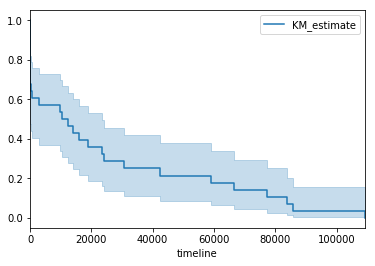

In [38]:
kmf.survival_function_
kmf.cumulative_density_
kmf.median_
kmf.plot_survival_function(); # or just kmf.plot()

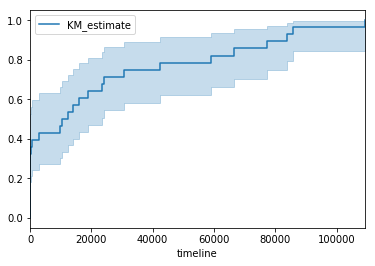

In [39]:
kmf.plot_cumulative_density();

#### CoxPHFitter

In [65]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)

In [24]:
reduced.head()

,date,device_id,ref_type_id,source_id,diff,diff_in_sec,observed
285338,2019-04-18 23:00:50.983090,3028036127478562480,1,0,23:00:50.983090,82850.983090,True
285339,2019-04-18 23:00:51.426613,7601431473174483609,1,0,23:00:51.426613,82851.426613,True
285340,2019-04-18 23:00:51.454013,5018235902686468387,1,0,23:00:51.454013,82851.454013,True
285341,2019-04-18 23:00:51.652223,5812445239233804650,7,0,23:00:51.652223,82851.652223,True
285342,2019-04-18 23:00:51.815673,8832711951922277816,7,0,23:00:51.815673,82851.815673,True


In [25]:
reduced.dtypes

date            datetime64[ns]
device_id               object
ref_type_id           category
source_id               object
diff           timedelta64[ns]
diff_in_sec            float64
observed                  bool
dtype: object

In [66]:
cph.fit(reduced.drop(['date', 'diff', 'source_id', 'day_of_week', 'hour'], axis=1), duration_col='diff_in_sec', event_col='observed', show_progress=True)
cph.print_summary()

Iteration 5: norm_delta = 0.00001, step_size = 1.0000, ll = -2463.99261, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 500 observations, 0 censored>
      duration col = 'diff_in_sec'
         event col = 'observed'
         penalizer = 0.1
number of subjects = 500
  number of events = 500
partial log-likelihood = -2463.99
  time fit was run = 2019-06-19 18:51:07 UTC

---
               coef exp(coef)  se(coef)      z      p  -log2(p)  lower 0.95  upper 0.95
device_id     -0.00      1.00      0.00  -0.84   0.40      1.31       -0.00        0.00
ref_type_id_1 -0.06      0.94      5.69  -0.01   0.99      0.01      -11.22       11.10
ref_type_id_7  0.06      1.06      5.69   0.01   0.99      0.01      -11.10       11.22
minute        -2.01      0.13      0.14 -14.54 <0.005    156.77       -2.28       -1.74
second        -0.03      0.97      0.00  -9.99 <0.005     75.63       -0.04       -0.03
---
Concorda

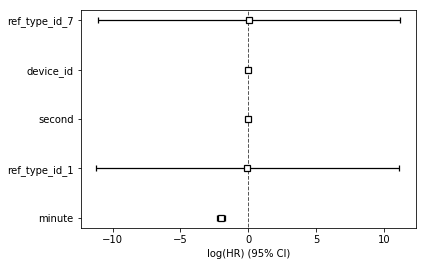

In [69]:
cph.plot();